In [1]:
import sklearn
from sklearn.datasets import fetch_20newsgroups
import numpy as np
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import pandas as pd
from pathlib import Path
import os

In [2]:
data_path = Path(os.getcwd())/'C:/Users/Yawan/Downloads/aclImdb'

In [3]:
train_path = data_path/'train'
test_path = data_path/'test'

In [4]:
def read_data(dir_path):
    """read data into pandas dataframe"""
    def load_dir_reviews(reviews_path):
        files_list = list(reviews_path.iterdir())
        reviews = []
        for filename in files_list:
            f = open(filename, 'r', encoding='utf-8')
            reviews.append(f.read())
        return pd.DataFrame({'text':reviews})
    pos_path = dir_path/'pos'
    neg_path = dir_path/'neg'
    pos_reviews, neg_reviews = load_dir_reviews(pos_path), load_dir_reviews(neg_path)
    pos_reviews['label'] = 1
    neg_reviews['label'] = 0
    merged = pd.concat([pos_reviews, neg_reviews])
    merged.reset_index(inplace=True)
    return merged

In [5]:
train = read_data(train_path)
test = read_data(test_path)

In [6]:
train=train[:-1] #one row less than test set

In [7]:
imdb_X_train, imdb_y_train = train['text'], train['label']
imdb_X_test, imdb_y_test = test['text'], test['label']

In [8]:
class TextProcess():
    
    def __init__(self, model):
        self.model = model
        self.vectorizer = CountVectorizer(ngram_range = (1,1), min_df=0, max_df=0.75)
        self.tfidf = TfidfTransformer(norm='l2', sublinear_tf = True)
        print(f"-------------------{str(self.model).split('(')[0]}---------------------")
        
# Modified some functions' inputs to fit the 2nd dataset   
    def fit(self, train_X, train_y):
        start_time = time.time()
        self.train_X = train_X
        self.train_y = train_y
        self.text_clf = Pipeline([('vect',self.vectorizer),('tfidf',self.tfidf),('clf',self.model)])
        self.text_clf.fit(self.train_X,self.train_y)
        self.time = (time.time()-start_time)
        print(f"Time to fit: {(time.time()-start_time):.3f}s")
        
    def predict(self, test_X, test_y):
        self.test_X = test_X
        self.test_y = test_y
        self.predicted = self.text_clf.predict(self.test_X)
        self.accuracy = np.mean(self.predicted == self.test_y)
        print(f"{str(self.model).split('(')[0]} accuracy: {self.accuracy*100:.2f}%")
        
    def classification_report(self):
        print(metrics.classification_report(self.test_y,self.predicted))
        
    def confusion_matrix(self):
        self.conf_matrix = metrics.confusion_matrix(self.test_y, self.predicted)
        for i,j in zip(self.conf_matrix,self.test_y):
            print(j)
            print(i)


In [9]:
model_list = [LogisticRegression(multi_class='auto', solver='liblinear',penalty='l2', C=6.3), DecisionTreeClassifier(criterion = 'gini', min_samples_split=92, splitter='random', min_samples_leaf=1), LinearSVC(C = 1, loss='squared_hinge', penalty='l2'), AdaBoostClassifier(learning_rate=0.5, n_estimators=160, base_estimator=DecisionTreeClassifier(max_depth=1)), RandomForestClassifier(min_samples_split=22, min_samples_leaf=1, n_estimators=600)]

In [10]:
time_list = []
accuracy_list = []
for model in model_list:
    processor = TextProcess(model)
    processor.fit(imdb_X_train, imdb_y_train)
    processor.predict(imdb_X_test, imdb_y_test)
    processor.classification_report()
    processor.confusion_matrix()
    time_list.append(processor.time)
    accuracy_list.append(processor.accuracy*100)

-------------------LogisticRegression---------------------
Time to fit: 7.799s
LogisticRegression accuracy: 88.66%
              precision    recall  f1-score   support

           0       0.88      0.89      0.89     12500
           1       0.89      0.88      0.89     12499

    accuracy                           0.89     24999
   macro avg       0.89      0.89      0.89     24999
weighted avg       0.89      0.89      0.89     24999

1
[11144  1356]
1
[ 1480 11019]
-------------------DecisionTreeClassifier---------------------
Time to fit: 41.853s
DecisionTreeClassifier accuracy: 71.29%
              precision    recall  f1-score   support

           0       0.71      0.73      0.72     12500
           1       0.72      0.70      0.71     12499

    accuracy                           0.71     24999
   macro avg       0.71      0.71      0.71     24999
weighted avg       0.71      0.71      0.71     24999

1
[9098 3402]
1
[3776 8723]
-------------------LinearSVC-------------------

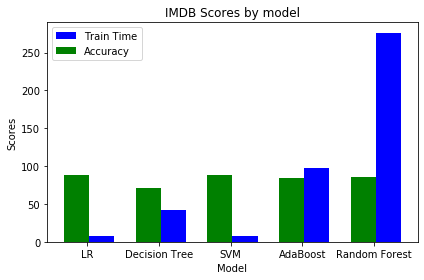

In [11]:
n_groups = len(time_list)
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
rects1 = plt.bar(index+bar_width, time_list, bar_width, alpha=1, label='Train Time', color='b')
rects2 = plt.bar(index, accuracy_list, bar_width, alpha=1, label='Accuracy', color='g')
plt.xlabel('Model')
plt.ylabel('Scores')
plt.title('IMDB Scores by model')
plt.xticks(index + bar_width-0.2, ('LR', 'Decision Tree', 'SVM', 'AdaBoost', 'Random Forest'))
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
def report(results, top=3):
    for i in range(1, top+1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

## Grid Search Cross Validation

### Logistic Regression

In [38]:
param_dist = {'clf__penalty': ['l2'],
              'clf__solver': ['liblinear'],
              'clf__C': np.linspace(0.1,5,5)}
clf = LogisticRegression(multi_class='auto')
text_clf = Pipeline([('vect',CountVectorizer(ngram_range=(1,2), min_df = 10, max_df = 1.)),('tfidf',TfidfTransformer()),('clf',clf)])
random_search = GridSearchCV(text_clf, param_grid = param_dist, cv=3)
start_time = time.time()
random_search.fit(imdb_X_train, imdb_y_test)
print("GridSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start_time), len(random_search.cv_results_['params'])))
report(random_search.cv_results_)

GridSearchCV took 280.50 seconds for 5 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.875 (std: 0.005)
Parameters: {'clf__C': 2.5500000000000003, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}

Model with rank: 2
Mean validation score: 0.875 (std: 0.005)
Parameters: {'clf__C': 3.7750000000000004, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}

Model with rank: 3
Mean validation score: 0.874 (std: 0.005)
Parameters: {'clf__C': 5.0, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}



### Logistic regression with stopwords removed

In [45]:
param_dist = {'clf__penalty': ['l2'],
              'clf__solver': ['liblinear'],
              'clf__C': np.linspace(0.1,5,5)}
clf = LogisticRegression(multi_class='auto')
text_clf = Pipeline([('vect',CountVectorizer(stop_words='english', ngram_range=(1,2), min_df = 10, max_df = 1.)),('tfidf',TfidfTransformer()),('clf',clf)])
random_search = GridSearchCV(text_clf, param_grid = param_dist, cv=3)
start_time = time.time()
random_search.fit(imdb_X_train, imdb_y_test)
print("GridSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start_time), len(random_search.cv_results_['params'])))
report(random_search.cv_results_)

GridSearchCV took 224.56 seconds for 5 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.856 (std: 0.008)
Parameters: {'clf__C': 1.3250000000000002, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}

Model with rank: 2
Mean validation score: 0.852 (std: 0.009)
Parameters: {'clf__C': 2.5500000000000003, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}

Model with rank: 3
Mean validation score: 0.850 (std: 0.009)
Parameters: {'clf__C': 3.7750000000000004, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}



#### Removing stopwords does not improve accuracy, so we will be using the original dataset for the rest of the models.

### Decision Tree

In [46]:
param_dist = {'clf__criterion': ['gini'],
             'clf__min_samples_split': range(2,100,10)}
clf = DecisionTreeClassifier()
text_clf = Pipeline([('vect',CountVectorizer(ngram_range=(1,2), min_df = 10, max_df = 1.)),('tfidf',TfidfTransformer()),('clf',clf)])
grid_search = GridSearchCV(text_clf, param_grid = param_dist, cv=3)
start_time = time.time()
grid_search.fit(imdb_X_train, imdb_y_test)
print("GridSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start_time), len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

GridSearchCV took 1459.78 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.704 (std: 0.005)
Parameters: {'clf__criterion': 'gini', 'clf__min_samples_split': 82}

Model with rank: 2
Mean validation score: 0.703 (std: 0.009)
Parameters: {'clf__criterion': 'gini', 'clf__min_samples_split': 92}

Model with rank: 3
Mean validation score: 0.702 (std: 0.003)
Parameters: {'clf__criterion': 'gini', 'clf__min_samples_split': 2}



### SVM

In [48]:
param_dist = { 'clf__penalty': ['l2'],
              'clf__loss' : ['hinge', 'squared_hinge'],
              'clf__C' : np.linspace(0.1,2,5),
}

clf = LinearSVC()
text_clf = Pipeline([('vect',CountVectorizer(ngram_range=(1,2), min_df = 10, max_df = 1.)),('tfidf',TfidfTransformer()),('clf',clf)])
grid_search = GridSearchCV(text_clf, param_grid = param_dist, cv=3)
start_time = time.time()
grid_search.fit(imdb_X_train, imdb_y_test)
print("GridSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start_time), len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

C:\Users\Yawan\Anaconda3\envs\venv\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


GridSearchCV took 601.75 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.874 (std: 0.006)
Parameters: {'clf__C': 0.575, 'clf__loss': 'hinge', 'clf__penalty': 'l2'}

Model with rank: 2
Mean validation score: 0.873 (std: 0.005)
Parameters: {'clf__C': 0.1, 'clf__loss': 'squared_hinge', 'clf__penalty': 'l2'}

Model with rank: 3
Mean validation score: 0.872 (std: 0.007)
Parameters: {'clf__C': 0.575, 'clf__loss': 'squared_hinge', 'clf__penalty': 'l2'}



### AdaBoost

In [49]:
param_dist = { 'clf__n_estimators' : range(10, 500, 200),
              'clf__learning_rate' : np.linspace(0.5,2,3)
    
}

clf = AdaBoostClassifier(DecisionTreeClassifier())
text_clf = Pipeline([('vect',CountVectorizer(ngram_range=(1,2), min_df = 10, max_df = 1.)),('tfidf',TfidfTransformer()),('clf',clf)])
grid_search = GridSearchCV(text_clf, param_grid = param_dist, cv=3)
start_time = time.time()
grid_search.fit(imdb_X_train, imdb_y_test)
print("GridSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start_time), len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

GridSearchCV took 2228.89 seconds for 9 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.704 (std: 0.006)
Parameters: {'clf__learning_rate': 0.5, 'clf__n_estimators': 210}

Model with rank: 2
Mean validation score: 0.704 (std: 0.005)
Parameters: {'clf__learning_rate': 2.0, 'clf__n_estimators': 410}

Model with rank: 3
Mean validation score: 0.703 (std: 0.002)
Parameters: {'clf__learning_rate': 0.5, 'clf__n_estimators': 10}



### Random Forest

In [ ]:
param_dist = {'clf__n_estimators' : range(10, 500, 200),
              'clf__min_samples_split': range(2,100,10)
}

clf = RandomForestClassifier()
text_clf = Pipeline([('vect',CountVectorizer(ngram_range=(1,2), min_df = 10, max_df = 1.)),('tfidf',TfidfTransformer()),('clf',clf)])
grid_search = GridSearchCV(text_clf, param_grid = param_dist, cv=3)
start_time = time.time()
grid_search.fit(imdb_X_train, imdb_y_test)
print("GridSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start_time), len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)